<a href="https://colab.research.google.com/github/Billl-11/CNN-Horse-vs-Human-Classifier/blob/main/CNN_Horse_and_Human_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - Horse vs Human Classifier

This is an implementation of the Convolutional Neural Network model and InceptionV3 pre-trained model to classify horse or human images.

## Datasets Preparation
There are two types of datasets, which is training datasets and validation datasets. Training datasets are the data that is used to tell the neural network model that "this is what a horse looks like" and "this is what a human looks like". Validation datasets are the data that is used to check the accuracy of the model from new images

In [1]:
# Download the training datasets
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation datasets
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2023-06-25 06:57:19--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  40.8MB/s    in 4.1s    

2023-06-25 06:57:23 (34.9 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2023-06-25 06:57:23--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114801

In [2]:
import zipfile

# extract training dataset
zip_file = zipfile.ZipFile('./horse-or-human.zip','r')
zip_file.extractall('./horse-or-human')

# extract validation dataset
zip_file = zipfile.ZipFile('./validation-horse-or-human.zip','r')
zip_file.extractall('./validation-horse-or-human')

> The contents of the .zip are extracted to the base directory ./horse-or-human for training and ./validation-horse-or-human for validating, which in turn each contain horses and humans subdirectories

## Data Augmentation


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled to 0-1, 255 as divisor because each color pixel has values ranging from 0 to 255.
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagenerator = ImageDataGenerator(rescale=1./255)

## Datasets Preprocessing
For this dataset, We do not have the label of each image as horses or humans. So, we will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) API instead that will automatically label images according to the directory names and structure. For example, we will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageDataGenerator will label the images appropriately.


In [4]:
TRAINING_DIR = '/content/horse-or-human'
VALIDATION_DIR = '/content/validation-horse-or-human'



train_generator = train_datagenerator.flow_from_directory(
    TRAINING_DIR, # parent directory that contain sub directory for labels
    target_size = (300,300), # make all data sizes uniform
    batch_size = 128, # during each iteration of training, the model will process 128 images from the dataset
    class_mode = 'binary' # we use binary mode because this is a two-class classification problem
)

validation_generator = validation_datagenerator.flow_from_directory(
    VALIDATION_DIR,
    target_size = (300,300),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Build the model

### Neural Network Layers

For model architecture, we will use neural network with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layer and [Pooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer.

- Convolution is applying filter to images to extract meaningful features from the input image
```
tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape(300,300,3))
```
Code above means a convolution layer with 64 filters, the filters will be 3x3 pixels in size, and the input image shape is 300x300 pixels in 3 color channels (RGB)

- Pooling layer  is used for downscaling and spatial dimension reduction
```
tf.keras.layers.MaxPooling2D(2,2)
```
The code above means picking the highest pixel values from 2x2 grid pixels, to capture the most important features by selecting the maximum response within each pooling region and reduces the spatial dimensions of the feature obtained from the previous convolutional layers.

- We use `activation='sigmoid'` in the last layer to make the output value of neural network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([

    # first convolution and pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # second convolution and pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # third convolution and pooling layer
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # forth convolution and pooling layer
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),

    # add a dropout rate of 0.2
    tf.keras.layers.Dropout(0.2),

    # hidden layer with 512 neuron
    tf.keras.layers.Dense(128, activation='relu'),

    # hidden layer with 512 neuron
    tf.keras.layers.Dense(512, activation='relu'),

    # last/output layer, with 1 neuron and sigmoid function where the range is 0-1 because its the probability of 2 classes (either zero or one)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

### Loss and optimizer
- To calculate the loss function, we use `loss = binary_crossentropy` because it's a binary classification problem
- For optimizer, we use [RMSprob optimization algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) with learning rate = 0.0001

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.0001),
              metrics = ['accuracy'])

### Model training
 We can observe on how fast the model trains and the accuracies we getting in the train and validation sets.

In [8]:
history_cnn = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=25,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/25
8/8 - 48s - loss: 0.6915 - accuracy: 0.5161 - val_loss: 0.7025 - val_accuracy: 0.5000 - 48s/epoch - 6s/step
Epoch 2/25
8/8 - 26s - loss: 0.6940 - accuracy: 0.5295 - val_loss: 0.6916 - val_accuracy: 0.5000 - 26s/epoch - 3s/step
Epoch 3/25
8/8 - 28s - loss: 0.6872 - accuracy: 0.6514 - val_loss: 0.6878 - val_accuracy: 0.5000 - 28s/epoch - 3s/step
Epoch 4/25
8/8 - 26s - loss: 0.6807 - accuracy: 0.6018 - val_loss: 0.6819 - val_accuracy: 0.5742 - 26s/epoch - 3s/step
Epoch 5/25
8/8 - 25s - loss: 0.6618 - accuracy: 0.6429 - val_loss: 0.7134 - val_accuracy: 0.5000 - 25s/epoch - 3s/step
Epoch 6/25
8/8 - 25s - loss: 0.6470 - accuracy: 0.6340 - val_loss: 0.6771 - val_accuracy: 0.5000 - 25s/epoch - 3s/step
Epoch 7/25
8/8 - 25s - loss: 0.6252 - accuracy: 0.6774 - val_loss: 0.7016 - val_accuracy: 0.5000 - 25s/epoch - 3s/step
Epoch 8/25
8/8 - 25s - loss: 0.6030 - accuracy: 0.6997 - val_loss: 0.7896 - val_accuracy: 0.5000 - 25s/epoch - 3s/step
Epoch 9/25
8/8 - 25s - loss: 0.5931 - accuracy: 

## Transfer Learning
To further enhance the classification performance, lets implement transfer learning from the InceptionV3 model. InceptionV3 is a deep convolutional neural network architecture pre-trained on a large-scale dataset, including various object categories.

### Download pretrained weights

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-25 07:12:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.1MB/s    in 2.9s    

2023-06-25 07:12:26 (29.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### Set-up the model
The pretrained model created with
- `include_top = False` where it means that the top classification layer is excluded or ignored
- `weights = None` means ignore the built-in weights from pretrained model

Next, the pre-trained weights are loaded into the `pretrained_model` by calling `load_weights` and passing the path to the weights file

Finally, the layers of the model are frozen by setting `layer.trainable = False` for each layer in the `pretrained_model`

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

transfer_file ='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(300,300,3),
                               include_top = False,
                               weights = None)

# Load the pre-trained weights you downloaded.
pretrained_model.load_weights(transfer_file)

# Freeze the weights of the layers.
for layer in pretrained_model.layers:
  layer.trainable = False

### Define new model

We are not going to use the whole pre-trained model, instead we use `"mixed7"` layer as the last layer for further processing

In [11]:
# Choose `mixed_7` as the last layer of our base model
layer_name = 'mixed7'
last_layer = pretrained_model.get_layer(layer_name)
print(f'{layer_name} layer output shape: {last_layer.output_shape}')
last_output = last_layer.output

mixed7 layer output shape: (None, 17, 17, 768)


In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pretrained_model.input, x)

### Loss, optimizer, and training
We will use the same loss function, optimizer, and training parameters as our previous CNN model

In [13]:
model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.00015),
              metrics = ['accuracy'])

history_inception = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=25,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/25
8/8 - 43s - loss: 1.5542 - accuracy: 0.6552 - val_loss: 0.3501 - val_accuracy: 0.8906 - 43s/epoch - 5s/step
Epoch 2/25
8/8 - 25s - loss: 0.0557 - accuracy: 0.9867 - val_loss: 0.1835 - val_accuracy: 0.9297 - 25s/epoch - 3s/step
Epoch 3/25
8/8 - 26s - loss: 0.0356 - accuracy: 0.9878 - val_loss: 0.1454 - val_accuracy: 0.9375 - 26s/epoch - 3s/step
Epoch 4/25
8/8 - 28s - loss: 0.0186 - accuracy: 0.9971 - val_loss: 0.1774 - val_accuracy: 0.9336 - 28s/epoch - 4s/step
Epoch 5/25
8/8 - 25s - loss: 0.0125 - accuracy: 0.9989 - val_loss: 0.1753 - val_accuracy: 0.9375 - 25s/epoch - 3s/step
Epoch 6/25
8/8 - 26s - loss: 0.0126 - accuracy: 0.9989 - val_loss: 0.2800 - val_accuracy: 0.9102 - 26s/epoch - 3s/step
Epoch 7/25
8/8 - 26s - loss: 1.0759 - accuracy: 0.7675 - val_loss: 0.3369 - val_accuracy: 0.8945 - 26s/epoch - 3s/step
Epoch 8/25
8/8 - 25s - loss: 0.0116 - accuracy: 0.9978 - val_loss: 0.1761 - val_accuracy: 0.9414 - 25s/epoch - 3s/step
Epoch 9/25
8/8 - 26s - loss: 0.0123 - accuracy: 

## Model Comparison

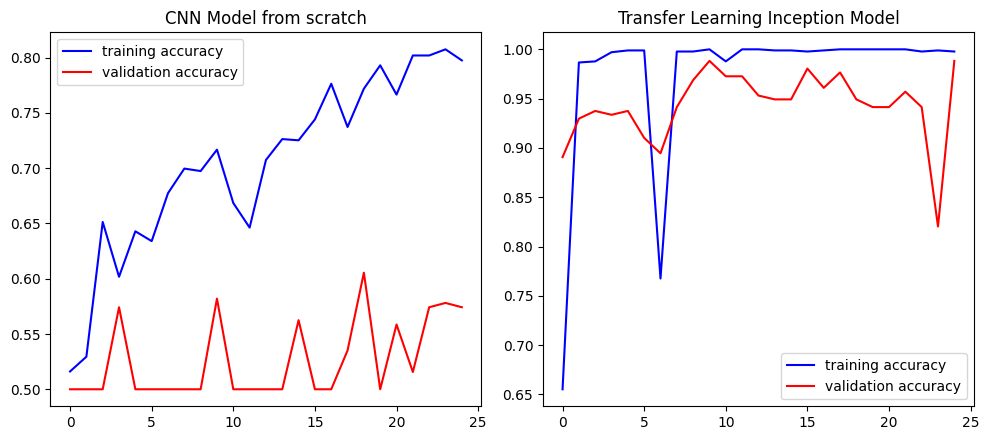

In [23]:
import matplotlib.pyplot as plt


acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

acc_inception = history_inception.history['accuracy']
val_acc_inception= history_inception.history['val_accuracy']

epochs = range(len(acc_cnn))

# figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

# Plot CNN model in the first subplot
axes[0].plot(epochs, acc_cnn, color= 'blue', label = 'training accuracy')
axes[0].plot(epochs, val_acc_cnn, color= 'red', label = 'validation accuracy')
axes[0].set_title('CNN Model from scratch')
axes[0].legend()

# Plot InceptionV3 in the second subplot
axes[1].plot(epochs, acc_inception, color= 'blue', label = 'training accuracy')
axes[1].plot(epochs, val_acc_inception, color= 'red', label = 'validation accuracy')
axes[1].set_title('Transfer Learning Inception Model')
axes[1].legend()

plt.tight_layout()

plt.show()


After training the models for 25 epochs, it can be concluded that the transfer learning approach resulted in better training and validation accuracy compared to training the models from scratch. This conclusion is based on the analysis of the training and validation accuracy trends throughout the 25 epochs.

By using transfer learning, which leverages pre-trained models like InceptionV3, the models benefited from the learned features and representations from a large dataset. This enabled the models to achieve higher accuracy during training and generalization to the validation dataset.

## Model Prediction
After training is finished, we can use the model to predict uploaded images

Saving istockphoto-1308644408-612x612.jpg to istockphoto-1308644408-612x612.jpg
Saving horse-3.jpg to horse-3.jpg


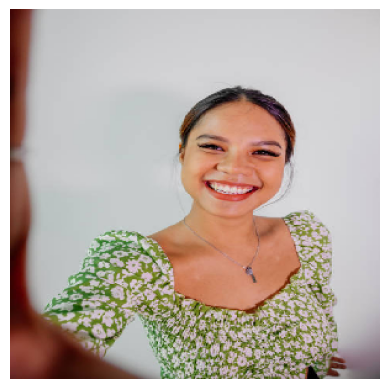

1/1 [==============================] - 0s 26ms/step
[0.9642752]
istockphoto-1308644408-612x612.jpg is a human



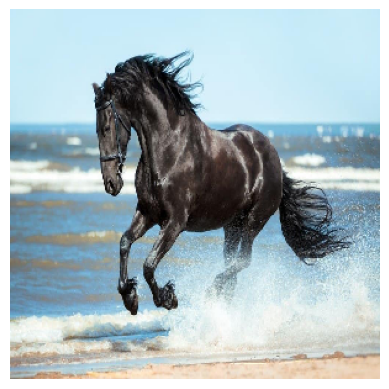

1/1 [==============================] - 0s 35ms/step
[1.4870852e-05]
horse-3.jpg is a horse



In [31]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  print()